<div align="center">
<a href="https://vbti.nl"><img src="https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX" width="400"></a>
</div>



# Multi-Layer Perceptron
The invention of the **Multi-Layer Perceptron (MLP)** and its update rule (**backpropagation**) are the most important breakthroughs in artificial neural networks from the 80ties and 90ties. As you learned from the previous chapter, a perceptron's primary limitation is that it can only divide a data space linearly. An MLP consists of layers of individual perceptrons. Therefore, MLP can approximate any continuous nonlinear function.

## Learning objectives
This chapter discusses the fundamentals of MLPs.

- Understand the mathematical model of an MLP.
- Understand the backpropagation training rule.
- Train an MLP on a given dataset (XOR Problem & Circle Problem) and evaluate its performance.

In [26]:
def download_file(url, path):
    import os
    import requests

    if os.path.exists(path):
        print('File', path, 'already exists. Skipping download...')
        return
    
    r = requests.get(url, allow_redirects=True)
    open(path, 'wb').write(r.content)
    print('Downloaded:', path, 'from', url)

download_file("https://raw.githubusercontent.com/illyakaynov/masterclass-ann-jads-12-feb/master/default_setup.py",
              "default_setup.py")
download_file("https://raw.githubusercontent.com/illyakaynov/masterclass-ann-jads-12-feb/master/support.py",
              "support.py")

%run default_setup.py
%load_ext autoreload
%autoreload 2
%matplotlib inline

np.random.seed(2020)

File: default_setup.py already exists. Skipping download...
Loaded numpy 1.19.2 as np.
Loaded pandas 1.1.3 as pd
Loaded matplotlib.pyplot 3.3.2 as plt
Loaded seaborn 0.11.0 as sns
Loaded tensorflow as tf 2.1.0.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Multi-Layer Perceptron

In the previous chapter, you learned about the perceptron. The perceptron is capable of linearly separating data into two classes. However, not all datasets can be linearly separated. We have seen examples of this: the XOR dataset and the circular datasets cannot be solved by a single line. The perceptron can handle these datasets using *feature engineering*, i.e., by adding extra inputs. For the XOR dataset the feature $ x_1 \cdot x_2 $ turned out to work well, and for the circular dataset the feature $ x_1 ^ 2 + x_2 ^ 2 $ was very useful. Feature engineering is a powerful machine learning technique. Still, it is error-prone, and most of the time requires domain knowledge. If we could learn these features, we would have a much more powerful machine learning model. This appears to be possible by combining several perceptrons in one model. This idea is also inspired by the functioning and structure of the brain. If we look in detail at the brain tissue, it appears that it is made up of layers of neurons.

<div align="center">
<img src="https://drive.google.com/uc?id=1HwhcrIs6iKGd06u5Sa5CgfvWNvUJWQwd" width="800">
</div>

## Function approximation

One of the early theoretical results of the Multi-Layer Perceptron is that such a network can approximate any function. In other words, an MLP with a single layer is a *universal function approximator*. It was previously thought that single layer MLP is capable of addressing any machine learning problem. Although theoretically, this might be true, a single layer might not be the most efficient way of learning complex functions. Most of the time, accuracy can be improved by adding more layers. By sequentially feeding the output of one layer as input into the other, MLP can learn its own complex features. Moreover, deeper networks have more *capacity*, i.e., it can store more information. Therefore *Deep Neural Networks* can approximate more complex functions at the expense of higher training time.

An interpretation of an MLP is that each layer learns a particular set of features. The first layers learn simple features, while the layers further learn more complex features by combining these simple features.

## Layers

A layer consists of 1 or more perceptrons, usually called *neurons*. All neurons in a specific layer receive as inputs the outputs of the previous layer. To make the notation easier, we can use matrix multiplications. First, we express a *forward path*, i.e., getting output from the network given input. Second, we define a *backward path*, where we will perform gradient descent to optimize against a loss function.  

#### Forward Path
Lets have a look at how we can define a forward path for one layer. Since now we several perceptrons working together we can define them in a matrix $W_i$. Each row in this matrix can be thought of as one perceptron. We take an input $X$ multiply it by the weight matrix of the first layer $W_1$, add bias $b_1$ and apply non-linear activation function $f_1$. 

$$y_0 = f_1(X \cdot W_1 + b_1)$$

Then output of the first layer is fed into the next one. We can define a general rule in the following manner.

$$z_i = y_{i-1} \cdot W_i + b_i$$
$$y_i = f_i(z_i)$$

In the Python code it is going to look like following:

In [2]:
def layer_forward_path(y_prev, W, b, act_f):
    z = np.dot(y_prev, W) + b  
    return act_f(z), z

#### Backwards path
In order to update the weights of the network we use *backpropagation*. Here we are working backwards by taking the derivative of the output of the last layer with respect to the weights of the current layer.


Compute gradients with respect to activation function:
$$dz_{i-1} = dz_i \cdot f_i^{\prime}(z_i)$$


Compute gradients with respect to weights and biases:
$$dW_i = \frac{\partial L}{\partial W_i}= y_{i-1}^T \cdot dz_i$$
$$
db_i = \frac{\partial L}{\partial b_i} = dz_i
$$


Pass gradient further:
$$
dy_{i-1} = \frac{\partial L}{\partial y_{i-1}} = dz_i \cdot W_i^T
$$


Update weights and biases
$$W_i = W_i + \eta \cdot \frac{\partial L}{\partial W_i} =  W_i + \eta \cdot dW_i$$

$$b_i = b_i + \eta \cdot \frac{\partial L}{\partial b_i} = b_i + \eta \cdot db_i$$


In [3]:
def backward_path(layer_input, layer_z, prev_layer_grad, W, b, grad_act_f, lr):
    # Compute gradients with respect to activation function
    grad_z = prev_layer_grad * grad_act_f(layer_z)
    
    #Compute gradients with respect to weights and biases
    grad_weights = np.dot(layer_input.T, grad_z)
    grad_biases = grad_z.mean(axis=0)
    
    # Pass gradient further
    grad_y = np.dot(grad_z, W.T)
    
    # Update weights
    W = W - lr * grad_weights
    b = b - lr * grad_biases

    return grad_y, grad_z, W, b

### Activation function

The output of every layer is processed by the activation function. Without an activation function, MLP would only be capable of performing linear transformations. By using non-linear activation functions, we broaden the horizons of problems that can be solved with MLP. The activation function needs to be continuous and differentiable to be suitable for *gradient descent* optimization.

Many different activation functions have been developed over time. One of the most used are logistic function or ***sigmoid*** and hyperbolic tangent ***tanh***.

Now we need to define the loss and activation functions.

##### Sigmoid:
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

 $$ \frac{\partial}{\partial x}\sigma(x) = \sigma(x) \cdot (1 - \sigma(x))$$

##### Hyperbolic Tangent: $$tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$
$$\frac{\partial}{\partial x} tanh(x) =  1 - tanh^2(x)$$



In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def grad_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    
def grad_tanh(z):
    return (1 - tanh(z)**2) 

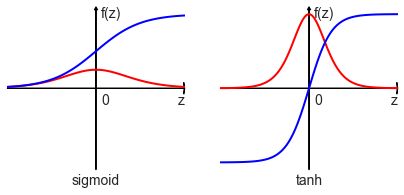

In [5]:
from support import plot_activation_function
fig, ax = plt.subplots(1,2, figsize=(7, 3))
plot_activation_function(sigmoid, grad_sigmoid, name='sigmoid', ax=ax[0], labels=('z', 'f(z)'), xlim=(-4, 4), ylim=(-1.1, 1.1))
plot_activation_function(tanh, grad_tanh, name='tanh', ax=ax[1], labels=('z', 'f(z)'), xlim=(-4, 4), ylim=(-1.1, 1.1))

#### Loss
We perform a forward path by pushing samples through the network. It is just a series of matrix multiplication with some non-linearity function in between. In this way, we get current predictions. Since we have correct answers, we can compare it to the network output and calculate the loss. The neural network is being optimized with respect to the error made on the existing samples. During the training, we adjust the weights with gradient descent to make the loss lower. By reducing the loss, we also hope that the network will get better at a certain task, e.g., classification. The loss functions usually differ per task. For this example we can use *Mean Squared Error*:

$$L(y, \hat y) = \frac{1}{2} (y - \hat y) ^ 2$$

$$\frac{\partial L(y, \hat y)}{\partial \hat y} = (y - \hat y)$$

In [6]:
import numpy as np

def mse_loss(y, y_pred):
    return np.mean((y - y_pred) ** 2) / 2

def grad_mse_loss(y, y_pred):
    return -np.mean(y - y_pred)

# We also define the accuracy function to calculate what fraction of the samples our model "got right"
def binary_accuracy(y_true, y_pred):
    accuracy = np.mean(1 - np.abs(y_pred.flatten() - y_true.flatten()))
    return accuracy

### Training
The training consists of *epochs*, the number of full passes through the dataset. First, we define one full *forward path* through all the layers. 

***We need to return all of the intermediate calculations to compute the gradients during training.***

In [7]:
def mlp_forward_path(X, weights, biases, act_f, train=False):
    # forward first layer
    y1, z1 = layer_forward_path(X, weights[0], biases[0], act_f=act_f)
    # forward second layer
    y2, z2 = layer_forward_path(y1, weights[1], biases[1], act_f=act_f)
    # forward third layer
    y3, z3 = layer_forward_path(y2, weights[2], biases[2], act_f=act_f)
    
    if train:
        return z1, y1, z2, y2, z3, y3
    
    return y3

Now we can define the back-propagation through all of the layers as well. To optimize the network with **Stochastic Gradient Descent** (SGD), you need to randomly sample *one* datapoint, evaluate the prediction, calculate the loss, and update the weights for all layers.

In [8]:
def mlp_train_epoch(X, y, weigths, biases, act_f, grad_act_f, lr=0.01):
    """
    This function performs one epoch training for Multi Layer Perceptron
    Parameters:
    ----------
        X : numpy.ndarray
            a matrix of datapoints [N, k], where N is the number of elemens k is number of features
        y : numpy.ndarray
            an array of labels
        weights : list[numpy.ndarray, ...]
            the list of weights [W_0, ..., W_L]
        biases : list[numpy.ndarray, ...]
            the list of biases [b_0, ..., b_L]
        act_f : python function
            activation function for hidden layers
        grad_act_f: python function
            gradient for the activation function
        lr: float
            learning rate, defines how much the parameters are adjusted during training
    Returns:
        loss: float
            mean loss for an epoch
    """
    # Forward path
    loss_epoch = []
    
    # Create an array of shuffled indices  
    idxs = np.random.choice(np.arange(X.shape[0]), size=(X.shape[0], ))
    for idx in idxs:
        # Sample an element from the dataset  
        X_sample, y_sample = X_train[[idx]], y_train[[idx]]
        # Forward path  
        z1, y1, z2, y2, z3, y3 = mlp_forward_path(X_sample, weigths, biases, act_f, train=True)

        # Calculate loss
        loss = mse_loss(y_sample, y3)
        loss_epoch.append(loss)
        
        # Calculate gradient of the loss
        loss_grad = grad_mse_loss(y_sample, y3)

        # Backward path
        y2_grad, z2_grad, weights[2], biases[2] = backward_path(layer_input=y2,
                                                                layer_z=z3,
                                                                prev_layer_grad=loss_grad,
                                                                W=weigths[2], b=biases[2],
                                                                grad_act_f=grad_act_f,
                                                                lr=lr)

        y1_grad, z1_grad, weights[1], biases[1] = backward_path(layer_input=y1,
                                                                layer_z=z2,
                                                                prev_layer_grad=y2_grad,
                                                                W=weigths[1], b=biases[1],
                                                                grad_act_f=grad_act_f,
                                                                lr=lr)

        _, _, weights[0], biases[0] = backward_path(layer_input=X_sample, layer_z=z1,
                                                                prev_layer_grad=y1_grad,
                                                                W=weigths[0], b=biases[0],
                                                                grad_act_f=grad_act_f,
                                                                lr=lr)
    return np.mean(loss_epoch)

 ### XOR dataset
 Now we will try to solve an XOR dataset with MLP. The architecture of the MLP allows hidden layers to learn representations of the data. We will show how MLP transforms a difficult problem into a linearly separatable one. 

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Test'}>

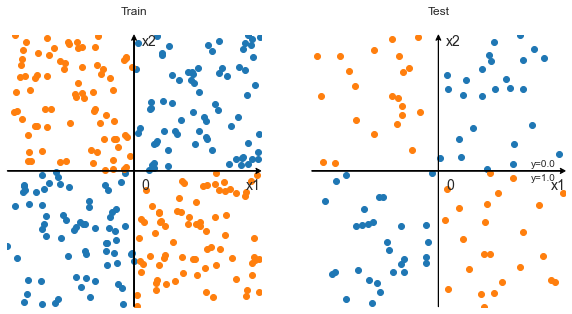

In [9]:
from support import make_xor_dataset, plot_dataset_2d

X, y = make_xor_dataset(400, r=3.)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_dataset_2d(X_train, y_train, ax=ax[0], title='Train')
plot_dataset_2d(X_test, y_test, ax=ax[1], title='Test')

### MLP architecture

We are going to build a small network for this problem. It is going to have two hidden layers with a size $4$ and $2$. Usually, in the classification tasks, the output size equals the number of classes. In binary classification, however, we can have one input. If we use a sigmoid function, the outputs values will be in the range [0, 1]. Therefore it can be interpreted as a probability distribution over two classes $p$ for *ones* and $1-p$ for *zeros*. $p$ then can be rounded by the following rule $\hat y = \mathbb{1}\{p \geq 0.5\}$.

<div align="center">
<img src="https://i.ibb.co/JR2mBpf/download-2.png" width="600">
</div>

In [10]:
# Lets setup the network architecture
n_layers = [4, 2, 1] # we don`t need to specify input layer since we are going to infer it from the data

# Lists to store our weights and biases
weights = []
biases = []

# Input dimension of the network.
input_dim = X.shape[-1]
current_input_dim = input_dim

for layer_size in n_layers:
#   size (shape) of the current layer
    size = (current_input_dim, layer_size)
    
#   Initialize weights randomly
    W = np.random.normal(loc=0.0, scale=0.5, size=size)
    weights.append(W)
#   Initialize biases with zeros
    b = np.zeros(layer_size)
    biases.append(b)
    
#   save the size of the previous layer
    current_input_dim = layer_size

print('Weights shapes:', [x.shape for x in weights])
print('Biases shapes:', [x.shape for x in biases])
history = {'loss': [], 'acc':[], 'val_acc': []}

Weights shapes: [(2, 4), (4, 2), (2, 1)]
Biases shapes: [(4,), (2,), (1,)]


<AxesSubplot:>

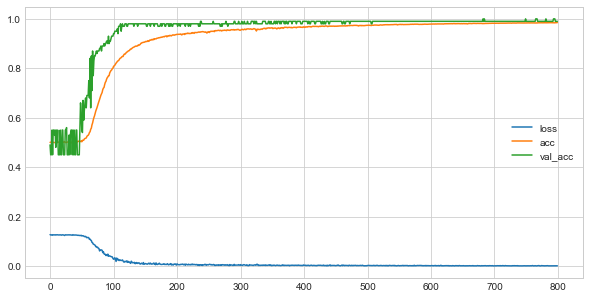

In [16]:
epochs = 200
learning_rate = 0.1

for epoch in range(epochs):

    loss = mlp_train_epoch(X_train, y_train,
                                weigths=weights,
                                biases=biases,
                                act_f=sigmoid,
                                grad_act_f=grad_sigmoid,
                                lr=learning_rate)
    history['loss'].append(loss)

    # Compute metrics
    y_pred = mlp_forward_path(X_train, act_f=sigmoid, weights=weights, biases=biases)
    acc = binary_accuracy(y_train, y_pred)
    history['acc'].append(acc)
    
    # Evaluate test set
    val_y_pred = mlp_forward_path(X_test, act_f=sigmoid, weights=weights, biases=biases)
    val_acc = binary_accuracy(y_test, np.round(val_y_pred))
    history['val_acc'].append(val_acc)
    
#   Uncomment the following lines to see how the performance of the network at each epoch
    # print('MSE train loss: {:.2f}'.format(loss))
    # print('Test accuracy: {:.2f}%'.format(100 * binary_accuracy(y_train, y_predicted)))
from support import plot_elements
plot_elements(history, elems=['loss', 'acc', 'val_acc'])

**Note:** You can rerun the cell above to train for more epochs.

#### Visualization of representations
Since we have two nodes in the last hidden layer, we can plot what the neuron in the last layer sees.

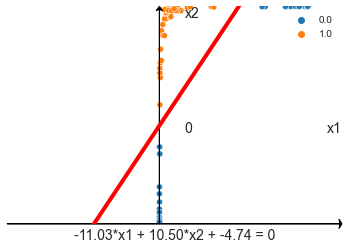

In [17]:
from support import plot_hyperplane

# Perform forward path only with two layers 
y1, z1 = layer_forward_path(X_train, weights[0], biases[0], act_f=sigmoid)
y2, z2 = layer_forward_path(y1, weights[1], biases[1], act_f=sigmoid)

# Plot the output of second layer 
ax = sns.scatterplot(
    x=y2[:, 0], y=y2[:, 1], hue=y_train)
# Plot the weights of the last layer as for the perceptron example
plot_hyperplane(ax, w1=weights[2][0].item(),
                w2=weights[2][1].item(), b=biases[2].item(),
                label=True, xlim=(-1, 1.2), ylim=(0, 1))

As in the case of the perceptron, the last neuron is linearly separating the data. The previous layers just learned how to make the problem simpler. It is easy to see that trained MLP is transforming the data to perform an easy linear separation as the last step.

### Cirle data

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Test'}>

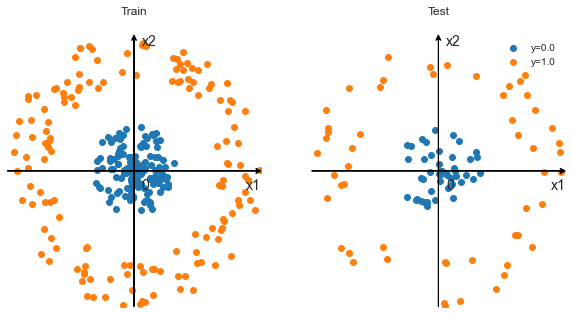

In [18]:
from support import make_circle_dataset
from sklearn.model_selection import train_test_split

X, y = make_circle_dataset(400, r=3.)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_dataset_2d(X_train, y_train, ax=ax[0], title='Train')
plot_dataset_2d(X_test, y_test, ax=ax[1], title='Test')

In [19]:
# Lets setup the network architecture
n_layers = [4, 2, 1] # we don`t need to specify input layer since we are going to infer it from the data

# Lists to store our weights and biases
weights = []
biases = []

# Input dimension of the network.
input_dim = X.shape[-1]
current_input_dim = input_dim

for layer_size in n_layers:
#   size (shape) of the current layer
    size = (current_input_dim, layer_size)
    
#   Initialize weights randomly
    W = np.random.normal(loc=0.0, scale=0.5, size=size)
    weights.append(W)
#   Initialize biases with zeros
    b = np.zeros(layer_size)
    biases.append(b)
    
#   save the size of the previous layer
    current_input_dim = layer_size

print('Weights shapes:', [x.shape for x in weights])
print('Biases shapes:', [x.shape for x in biases])
history = {'loss': [], 'acc':[], 'val_acc': []}

Weights shapes: [(2, 4), (4, 2), (2, 1)]
Biases shapes: [(4,), (2,), (1,)]


In [20]:
epochs = 200
learning_rate = 0.1

for epoch in range(epochs):

    loss = mlp_train_epoch(X_train, y_train,
                                weigths=weights,
                                biases=biases,
                                act_f=sigmoid,
                                grad_act_f=grad_sigmoid,
                                lr=learning_rate)
    history['loss'].append(loss)

    # Compute metrics
    y_pred = mlp_forward_path(X_train, act_f=sigmoid, weights=weights, biases=biases)
    acc = binary_accuracy(y_train, y_pred)
    history['acc'].append(acc)
    
    # Evaluate test set
    val_y_pred = mlp_forward_path(X_test, act_f=sigmoid, weights=weights, biases=biases)
    val_acc = binary_accuracy(y_test, np.round(val_y_pred))
    history['val_acc'].append(val_acc)
    
#   Uncomment the following lines to see how the performance of the network at each epoch
    # print('MSE train loss: {:.2f}'.format(loss))
    # print('Test accuracy: {:.2f}%'.format(100 * binary_accuracy(y_train, y_predicted)))

<AxesSubplot:>

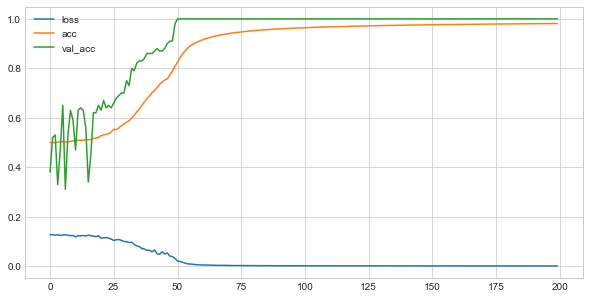

In [21]:
plot_elements(history, elems=['loss', 'acc', 'val_acc'])

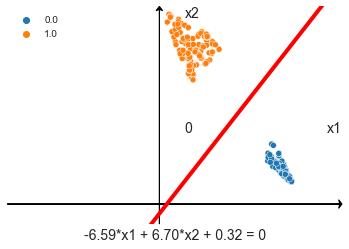

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

from support import plot_hyperplane

# Perform forward path only with two layers 
y1, z1 = layer_forward_path(X_train, weights[0], biases[0], act_f=sigmoid)
y2, z2 = layer_forward_path(y1, weights[1], biases[1], act_f=sigmoid)

# Plot the output of second layer 
ax = sns.scatterplot(x=y2[:, 0], y=y2[:, 1], hue=y_train)
# Plot the weights of the last layer as for the perceptron example
plot_hyperplane(ax, w1=weights[2][0].item(),
                w2=weights[2][1].item(), b=biases[2].item(),
                label=True, xlim=(-1, 1.2), ylim=(-0.1, 1))

## Putting Everything together.
In this notebook we have shown how to create a Multi-Layer Perceptron with Python and NumPy. In the following cell we have put everything together in a class. The weights and biases are being initialized by a constructor of the class `__init__()`. Now you can add layers manually, specify activation functions for the layers or even define your own loss losses. You can train the model by calling `fit()` method on the data. Go ahead and experiment with it.

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split

def binary_accuracy(y_true, y_pred):
    accuracy = np.mean(1 - np.abs(y_pred.flatten() - y_true.flatten()))
    return accuracy

def mse_loss(y, y_pred):
    return np.mean((y - y_pred) ** 2) / 2

def grad_mse_loss(y, y_pred):
    return -np.mean(y - y_pred)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def grad_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    
def grad_tanh(z):
    return (1 - tanh(z)**2) 

LOSSES = {
    'mse': (mse_loss, grad_mse_loss)
}

ACTIVATION_FUNCTIONS = {
    'sigmoid': (sigmoid, grad_sigmoid),
    'tanh': (tanh, grad_tanh)
}

class Model:
    def __init__(self):
        self.weights = []
        self.biases = []
        
        self.act_fs = []
        self.grad_act_fs = []
        self.n_layers = []
        
        self.loss = None
        self.grad_loss = None
        
        self.learning_rate = 0.01
        
        self._is_built = False
        
        self.metrics = {}
        
        
    def add_layer(self, units, act_f='sigmoid'):
        """
        Add a dense layer with a specified number of neurons and activation function
        to a model.
        
        Args:
            units (int): Number of neurons in a layer.
            act_f (str): Activation function keyword.
        Returns None:

        """
        self.n_layers.append(units)
        
        self.act_fs.append(ACTIVATION_FUNCTIONS[act_f][0])
        self.grad_act_fs.append(ACTIVATION_FUNCTIONS[act_f][1])
    
    def build(self, n_features):
        """
        Initialize weights and biases.
        """
        self.n_features = n_features
        
        current_input_dim = self.n_features
        for units in self.n_layers:
            size = (current_input_dim, units)
            
            self.weights.append(np.random.normal(loc=0.0, scale=0.5, size=size))
            self.biases.append(np.zeros(shape=(units,)))
            
            current_input_dim = units
        
        self._is_built = True
            
    def compile(self, loss='mse', learning_rate=0.01):
        """
        Add loss and choose learning rate for Stochastic Gradient Descent optimization
        Args:
            loss(str): keyword
        """
        self.loss = LOSSES[loss][0]
        self.grad_loss = LOSSES[loss][1]
        self.learning_rate = learning_rate
    
    def forward_path(self, x, training=False):
        """
        Perform Model inference on a batch
        
        Args:
            x(numpy.ndarray): input batch as matrix with shape (batch_size, num_features)
            training(bool): if True alongside with the predictions a cache current inputs is returned
            
        Returns:
            current_y(numpy.ndarray): output of the last layer
            cache(dict): dictionary of inputs of all layers thourgh the network for this batch
        """
        if not self._is_built:
            self.build(n_features=x.shape[-1])
        
        cache = {}
        current_input = x
        for i in range(len(self.n_layers)):
            current_z = np.dot(current_input, self.weights[i]) + self.biases[i]
            current_y = self.act_fs[i](current_z)
            cache[f'z_{i}'] = current_z
            cache[f'y_{i}'] = current_y
            current_input = current_y
        
        if training:
            return current_y, cache
        return current_y
    
    def train_on_batch(self, x, y):
        """
        Perform a Stochastic Gradient Descent on a mini-batch of data

        Args:
            x(numpy.ndarray): input batch as matrix with shape (batch_size, num_features)
            y(numpy.ndarray): labels batch as vector with shape (batch_size, )
        """
        y_hat, cache = self.forward_path(x, training=True)
        
        loss = self.loss(y, y_hat)
        grad_loss = self.grad_loss(y, y_hat)
        
        prev_layer_grad = grad_loss
        for i in reversed(range(len(self.n_layers))):
            # Compute gradient of the activation function with respect to z value
            grad_z = prev_layer_grad * self.grad_act_fs[i](cache[f'z_{i}'])

            # compute gradient w.r.t. weights and biases
            if i == 0: # The y_0 is actually x
                grad_weights = np.dot(x.T, grad_z)
            else:
                grad_weights = np.dot(cache[f'y_{i-1}'].T, grad_z)
                
            grad_biases = grad_z.mean(axis=0)

            # Pass gradient further
            # compute d f / d x = d f / d dense * d dense / d x
            # where d dense/ d x = weights transposed
            prev_layer_grad = np.dot(grad_z, self.weights[i].T)

            # Update weights
            self.weights[i] -= self.learning_rate * grad_weights
            self.biases[i] -= self.learning_rate * grad_biases
        return y_hat, loss
    
    def fit(self, x, y, validation_split=0.2, epochs=50, batch_size=32, history=None):
        """
        Perform network training by randomly sampling a batch from the data
        Args:
            x(numpy.ndarray): training set (set_size, num_features)
            y(numpy.ndarray): labels(set_size, )
            validaton_split: if the validation_data is not provided reserve this fraction
                             of training set for the validation
        Returns:
            history(dict): a dictionary with training parameters recorded on epoch basis
            
        """
        if history is None:
            history = {metric_name: [] for metric_name in ['loss', 'val_loss', 'acc', 'val_acc']}
            
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split) 
        
        for epoch in range(epochs):
            idxs = np.random.choice(np.arange(X_train.shape[0]), size=(batch_size, ))
            batch_losses = []
            batch_accs = []
            for idx in idxs:
        #       Sample a batch from the dataset  
                X_batch, y_batch = X_train[[idx]], y_train[[idx]]
                y_batch_hat, loss = self.train_on_batch(X_batch, y_batch)
                batch_losses.append(loss)
                batch_accs.append(binary_accuracy(y_batch_hat, y_batch))
            
            y_hat = self.forward_path(X_val, training=False)
            
            history['loss'].append(np.mean(batch_losses))
            history['val_loss'].append(self.loss(y_batch, y_hat))
            history['acc'].append(np.mean(batch_accs))
            history['val_acc'].append(binary_accuracy(y_val, self.forward_path(X_val, training=False)))  
        return history
           

In [24]:
from support import plot_elements
# Create model
model = Model()
# Add layers with activation functions
model.add_layer(units=4, act_f='tanh')
model.add_layer(units=2, act_f='tanh')
model.add_layer(units=1, act_f='sigmoid')
# Add loss and specify learnin rate
model.compile(loss='mse', learning_rate=0.1)
# Store the history of training process
history = {metric_name: [] for metric_name in ['loss', 'val_loss', 'acc', 'val_acc']}

<AxesSubplot:>

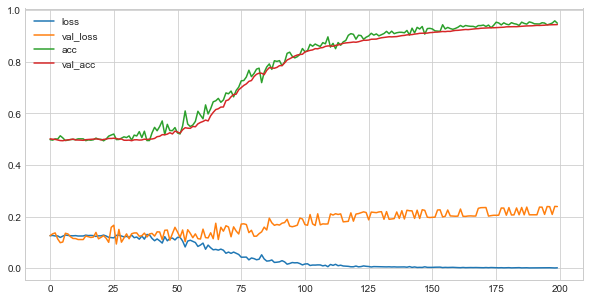

In [25]:
history = model.fit(X, y, epochs=200, batch_size=32, validation_split=0.2, history=history)       
plot_elements(history, elems=['loss','val_loss', 'acc', 'val_acc'])

**Note**: you can rerun the previous cell if you think that you need more training epochs. The weights are going to be reinitialized only when you create a new model.

## Questions (optional):
    - Try running the model with different number of nodes and layers, how does the performance change?
    - Try different batch sizes. How does batch size affect the training?
    - Try changing number of epochs and learning rate. How do they affect training?